## Overview

- Step 1 - Source Detection

- Step 2 - Iterative processing (per window)

>- (a) Isolate data – Select magnetic data inside window
>- (b) Euler deconvolution – Estimate source position
>- (c) Linear inversion – Estimate dipole moment using fixed position
>- (d) Non-linear inversion – Refine position & moment via Nelder-Mead
>- (e) Signal removal – Forward model dipole & subtract from full dataset

- Step 3 - Repeat detection on residual data: Apply steps 1 and 2 to the stripped dataset to identify new sources and compute their parameters

In [1]:
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
import xarray as xr
import skimage.exposure
import matplotlib.patches
import magali as mg

## Synthetic data

First a synthetic model is generated.

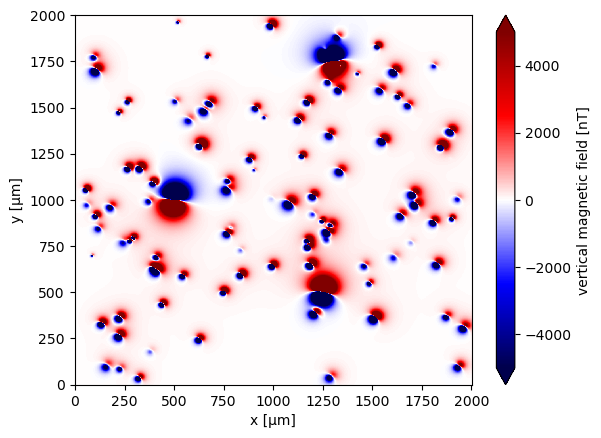

In [2]:
sensor_sample_distance = 5.0  # µm
region = [0, 2000, 0, 2000]  # µm
spacing = 2  # µm

true_inclination = 30
true_declination = 40
true_dispersion_angle = 5


size = 100

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipoles_amplitude = abs(np.random.normal(0, 100, size)) * 1.0e-14

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([directions_inclination, [10, -10, -5]]),
    declination=np.concatenate([directions_declination, [10, 170, 190]]),
    intensity=np.concatenate([dipoles_amplitude, [5e-11, 5e-11, 5e-11]]),
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)
data.plot.pcolormesh(cmap="seismic", vmin=-5000, vmax=5000)

## Anomaly detection

- Upward continuation
- Total Gradient Amplitude (TGA): Enhances signal near the source (high-pass filter)
- Contrast stretching: Uses percentiles (1st and 99th) to enhance weak particles
- LoG (Laplacian of Gaussian) segmentation: Detects “blobs” → 1 window = 1 particle
- Rank by decreasing signal strength

### Upward continuation

Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


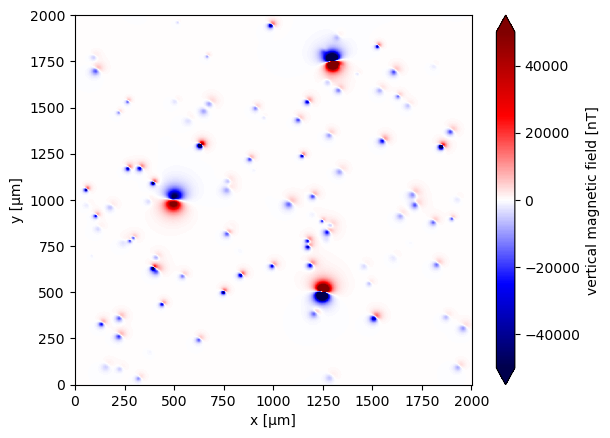

In [3]:
height_difference = 5


data_up = (
    hm.upward_continuation(data, height_difference)
    .assign_attrs(data.attrs)
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

### Total Gradient Amplitude

To enhance signal near the source (high-pass filter), the Total Gradient Amplitude (TGA) is used.

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


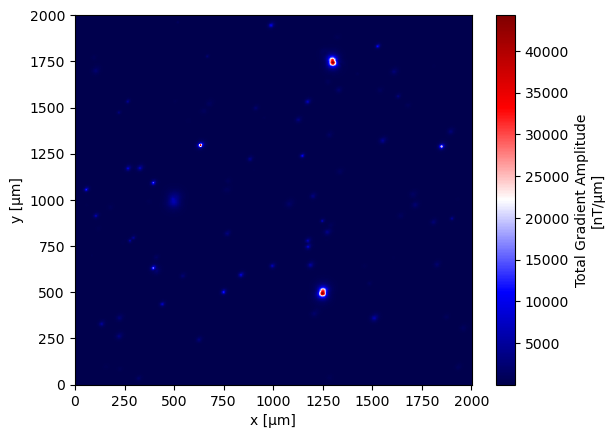

In [4]:
data_tga = mg.total_gradient_amplitude_grid(data_up)
data_tga.plot.pcolormesh(cmap="seismic")

### Contrast stretching

Rescale TGA values to highlight both weak and strong signals. 

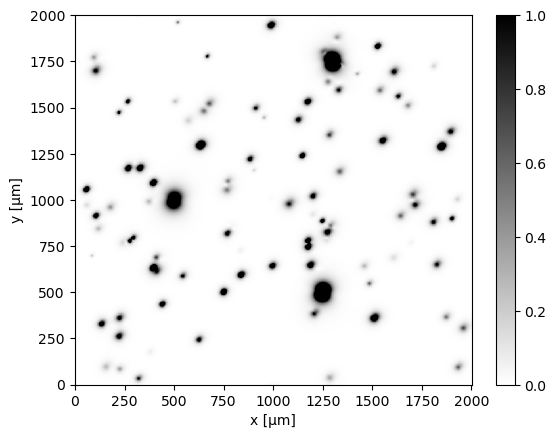

In [5]:
data_stretched = skimage.exposure.rescale_intensity(
    data_tga, 
    in_range=tuple(np.percentile(data_tga, (1, 99))),
)
data_stretched.plot.pcolormesh(cmap="gray_r")

### Laplacian of Gaussian (LoG) segmentation

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [6]:
windows = mg.detect_anomalies(
    data_stretched,
    size_range=[25, 50],
    size_multiplier=2,
    num_scales=10,
    detection_threshold=0.01,
    overlap_ratio=0.5,
    border_exclusion=1,
)

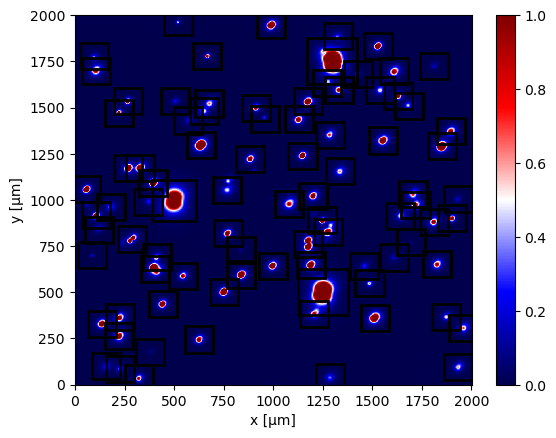

In [7]:
ax = plt.subplot(111)
data_stretched.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)  